# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [3]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [4]:
df = pd.read_csv('sentiment_5400.csv')
df.head(10)

,content,sentimen
0,bogor keluarga fw 22 perempuan dibunuh pacarny...,negatif
1,khoiri 52 warga dusun blimbing desa parerejo k...,negatif
2,polisi menangkap andrea cw inggris chansler am...,negatif
3,wakil ketua umum pan yandri susanto capres ani...,negatif
4,pria medan satria kota bekasi terluka lehernya...,negatif
5,kpu ri menilai surat suara taipei taiwan surat...,negatif
6,jet jet tempur israel melancarkan serangan uda...,negatif
7,rumah milik mf 16 remaja diduga mencekik bocah...,negatif
8,calon presiden ganjar pranowo relawannya ikuta...,negatif
9,calon wakil presiden cawapres nomor urut 1 muh...,negatif


In [5]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [6]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [7]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [8]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [9]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

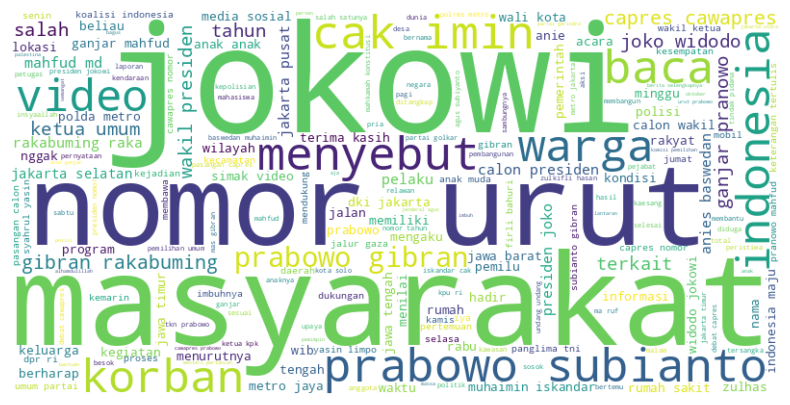

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Membuat vektor TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['content'])

# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Menampilkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lsa_model.components_):
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    print(f"Topik {i+1}: {', '.join(top_terms)}")


Topik 1: presiden, cawapres, ganjar, gibran, prabowo
Topik 2: gaza, syl, israel, firli, kpk
Topik 3: palestina, serangan, hamas, gaza, israel
Topik 4: cak, imin, anies, mahfud, ganjar
Topik 5: presiden, tni, mahfud, ganjar, jokowi
Topik 6: kpk, gaza, israel, mahfud, ganjar
Topik 7: presiden, cak, imin, jokowi, anies
Topik 8: putusan, debat, konstitusi, tni, mk
Topik 9: hakim, putusan, mahkamah, konstitusi, mk
Topik 10: presiden, pan, zulhas, jokowi, debat


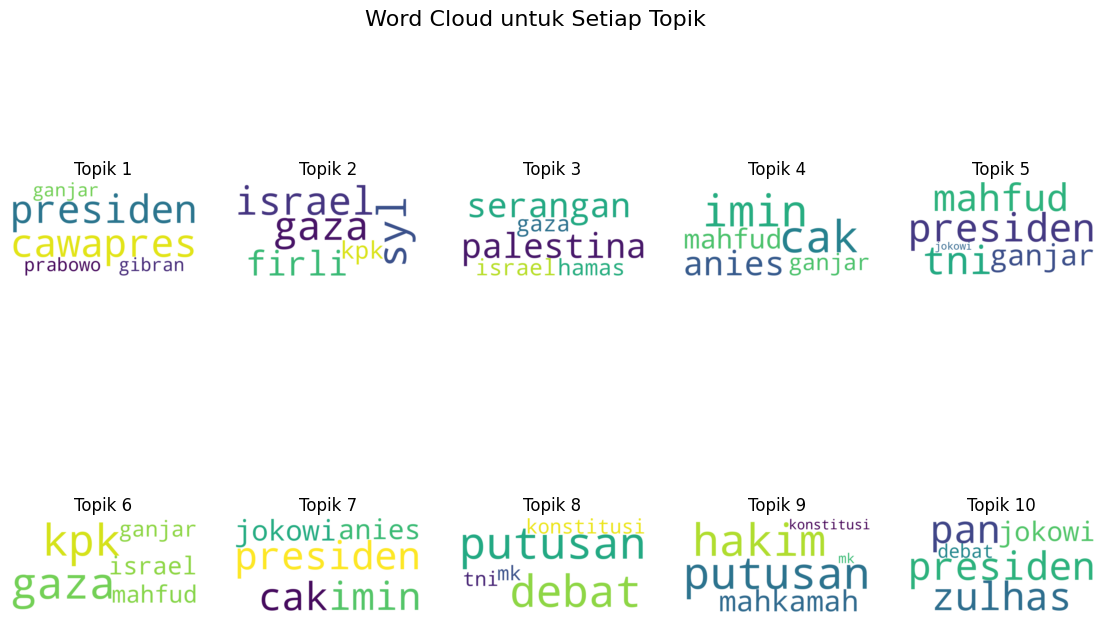

In [12]:
# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Mendapatkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
top_terms_per_topic = []
for topic in lsa_model.components_:
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    top_terms_per_topic.append(top_terms)

# Word Cloud
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_terms_per_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topik {i+1}')
    plt.axis('off')
plt.suptitle('Word Cloud untuk Setiap Topik', fontsize=16)
plt.show()

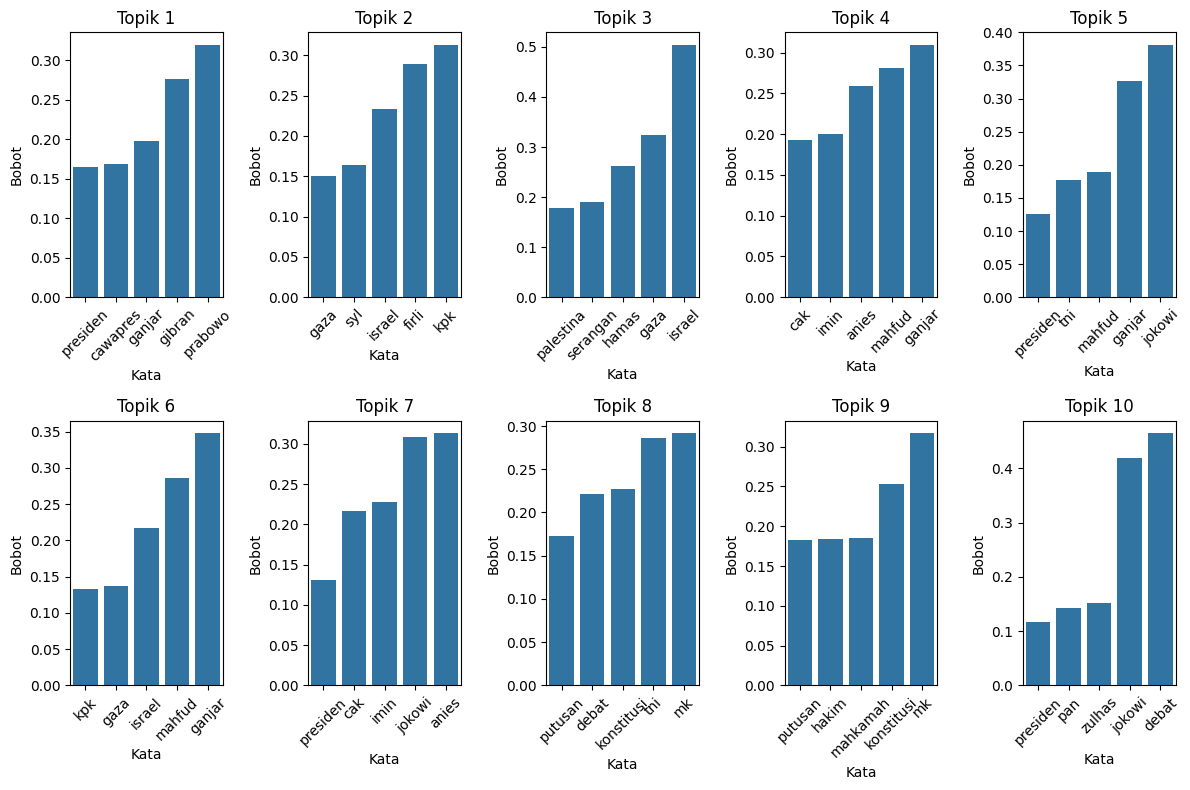

In [13]:
import seaborn as sns
# Bar Plot Topik Kata untuk LSA
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    top_terms = [terms[j] for j in lsa_model.components_[i].argsort()[-5:]]
    top_weights = sorted(lsa_model.components_[i])[-5:]
    sns.barplot(x=top_terms, y=top_weights)
    plt.title(f'Topik {i+1}')
    plt.xlabel('Kata')
    plt.ylabel('Bobot')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Naiye Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [15]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [16]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 77.96296296296296
TF-IDF Vectorization F1 Score: 77.71521714633128
Bag of Words (BoW) Accuracy: 78.02469135802468
Bag of Words (BoW) F1 Score: 77.79587117606845
Combined TF-IDF and BoW Accuracy: 78.2716049382716
Combined TF-IDF and BoW F1 Score: 78.01848631315339


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 79.75308641975309
TF-IDF Vectorization F1 Score: 79.59697593897329
Bag of Words (BoW) Accuracy: 80.0
Bag of Words (BoW) F1 Score: 79.83535018851438
Combined TF-IDF and BoW Accuracy: 79.81481481481481
Combined TF-IDF and BoW F1 Score: 79.64766655599486


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 87.1604938271605
TF-IDF Vectorization F1 Score: 87.12522288936832
Bag of Words (BoW) Accuracy: 86.97530864197532
Bag of Words (BoW) F1 Score: 86.95157594109493
Combined TF-IDF and BoW Accuracy: 87.5925925925926
Combined TF-IDF and BoW F1 Score: 87.57460154413972


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=100, gamma=0.1, kernel='linear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 87.4074074074074
TF-IDF Vectorization F1 Score: 87.37759517771214
Bag of Words (BoW) Accuracy: 87.09876543209877
Bag of Words (BoW) F1 Score: 87.09130512638754
Combined TF-IDF and BoW Accuracy: 87.53086419753086
Combined TF-IDF and BoW F1 Score: 87.51246236405602


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 83.33333333333334
TF-IDF Vectorization F1 Score: 83.2366064181109
Bag of Words (BoW) Accuracy: 85.55555555555556
Bag of Words (BoW) F1 Score: 85.5063761201954
Combined TF-IDF and BoW Accuracy: 86.23456790123457
Combined TF-IDF and BoW F1 Score: 86.19764762941871


#### Parameter

In [23]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 86.72839506172839
TF-IDF Vectorization F1 Score: 86.69678513829533
Bag of Words (BoW) Accuracy: 86.85185185185185
Bag of Words (BoW) F1 Score: 86.83422737552628
Combined TF-IDF and BoW Accuracy: 86.79012345679013
Combined TF-IDF and BoW F1 Score: 86.7617739190154


## Model Random Forest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [25]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 82.96296296296296
TF-IDF Vectorization F1 Score: 82.66841163414288
Bag of Words (BoW) Accuracy: 83.58024691358025
Bag of Words (BoW) F1 Score: 83.3518781948771
Combined TF-IDF and BoW Accuracy: 83.08641975308642
Combined TF-IDF and BoW F1 Score: 82.80619723737766


#### Parameter

In [26]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,n_estimators=200,random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 82.8395061728395
TF-IDF Vectorization F1 Score: 82.55158839994787
Bag of Words (BoW) Accuracy: 82.46913580246914
Bag of Words (BoW) F1 Score: 82.21766380552947
Combined TF-IDF and BoW Accuracy: 82.71604938271605
Combined TF-IDF and BoW F1 Score: 82.47432476638902


## Model Ensemble Learning

In [27]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [28]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [29]:
# Membuat model ensemble
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [30]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 86.72839506172839
TF-IDF Vectorization F1 Score: 86.71345365858575
Bag of Words (BoW) Accuracy: 87.4074074074074
Bag of Words (BoW) F1 Score: 87.40909035312293
Combined TF-IDF and BoW Accuracy: 86.91358024691358
Combined TF-IDF and BoW F1 Score: 86.90460628306123


#### 3 Model

In [31]:
ensemble_model_3 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [32]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_3 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_3 , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_3 , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 87.4074074074074
TF-IDF Vectorization F1 Score: 87.36244589548893
Bag of Words (BoW) Accuracy: 88.08641975308642
Bag of Words (BoW) F1 Score: 88.06224172478157
Combined TF-IDF and BoW Accuracy: 88.20987654320987
Combined TF-IDF and BoW F1 Score: 88.17269963307334


#### 2 Model

In [33]:
ensemble_model_2 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [34]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_2 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_2, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_2, combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 87.46913580246914
TF-IDF Vectorization F1 Score: 87.47925995132563
Bag of Words (BoW) Accuracy: 86.41975308641975
Bag of Words (BoW) F1 Score: 86.45163288711021
Combined TF-IDF and BoW Accuracy: 86.91358024691358
Combined TF-IDF and BoW F1 Score: 86.93009662121888
